Features and models used are based on: [Link Prediction in Social Networks using
Computationally Efficient Topological Features](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=9f3c2d5364aab82a24e24e56f6013cfc4c404e13)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


We can ignore node labels as we don't want predictions to be made based on them, but on features

In [19]:
from sklearn.feature_selection import mutual_info_classif
def prep_data(path):
    data = pd.read_csv(path)
    data.head()
    data = data.drop(['node_1', 'node_2'], axis = 'columns')
    label = data['link_exists']
    train_data = data.drop(['link_exists'], axis = 'columns')
    x_train, x_test, y_train, y_test = train_test_split(train_data, label, test_size=0.2, random_state=42)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    return x_train, y_train, x_test, y_test, x_valid, y_valid


In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

model_performance_data = pd.DataFrame(columns=['Dataset' ,'Model', 'Train Accuracy', 'Validation Accuracy','Test Accuracy'])

In [21]:
def train_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test):
    model.fit(x_train, y_train)
    acc_score_train = accuracy_score(y_train, model.predict(x_train))
    acc_score_valid = accuracy_score(y_valid, model.predict(x_valid))
    acc_score_test = accuracy_score(y_test, model.predict(x_test))
    return acc_score_train, acc_score_valid, acc_score_test

In [22]:
def model_performance(dataset, model, name, x_train, y_train, x_valid, y_valid, x_test, y_test):
    accuracy_score_train, accuracy_score_valid, accuracy_score_test = train_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test)
    model_performance_data.loc[len(model_performance_data.index)] = [dataset, name,
                                                                      accuracy_score_train, accuracy_score_valid, accuracy_score_test]

In [23]:
data = ['data/CondMat.csv', 'data/GenRel.csv']

for dataset in data:
    x_train, y_train, x_test, y_test, x_valid, y_valid = prep_data(dataset)
    model = GaussianNB()
    model_performance(dataset, model, 'GaussianNB', x_train, y_train, x_valid, y_valid, x_test, y_test)
    model = KNeighborsClassifier()
    model_performance(dataset, model, 'KNeigborsClassifier', x_train, y_train, x_valid, y_valid, x_test, y_test)
    model = AdaBoostClassifier(algorithm='SAMME')
    model_performance(dataset, model, 'AdaBoostClassifier', x_train, y_train, x_valid, y_valid, x_test, y_test)
    model = BaggingClassifier()
    model_performance(dataset, model, 'BaggingClassifier', x_train, y_train, x_valid, y_valid, x_test, y_test)
    model_performance_data.head()

model_performance_data.to_csv('model_performance.csv', index=False)

(182684, 15)
(26856, 15)


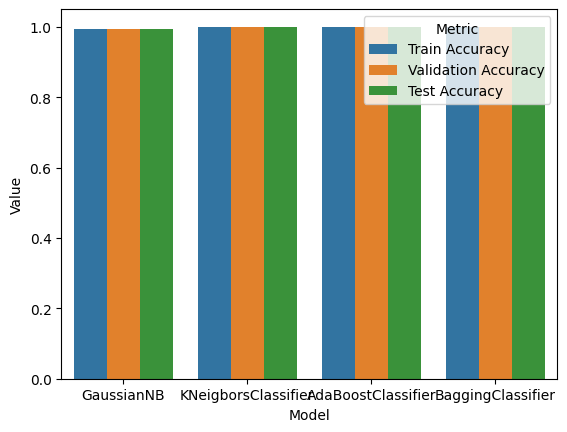

In [63]:
import seaborn as sns
dfm = pd.melt(model_performance_data, id_vars='Model', var_name='Metric', value_name='Value')
g = sns.barplot(data=dfm, x='Model', y='Value', hue='Metric')

In [64]:
import torch
from torch import nn

print(torch.cuda.is_available())

print(torch.cuda.device_count())


True
1


In [65]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [66]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [67]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [68]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
dataset = TensorDataset(pd.DataFrame.to_numpy(x_train, dtype=np.float64), pd.DataFrame.to_numpy(y_train, dtype=np.float64))
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

AttributeError: 'SingleBlockManager' object has no attribute 'as_array'

In [ ]:
model = NeuralNetwork()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
for epoch in range(4):
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{4}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    # Example test data
    test_X = torch.tensor(x_test.values, dtype=torch.float32)
    test_y = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    test_outputs = model(test_X)
    predicted = (test_outputs > 0.5).float()
    accuracy = (predicted == test_y).sum() / test_y.size(0)

    print(f'Accuracy: {accuracy:.4f}')

Epoch [1/4], Loss: 0.0008
Epoch [2/4], Loss: 0.0009
Epoch [3/4], Loss: 0.0020
Epoch [4/4], Loss: 0.0007
Accuracy: 0.9985
